In [1]:
import warnings
warnings.simplefilter(action='ignore')

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import numpy as np

In [2]:
df = pd.read_csv('Train_music_ForestImputer.csv')

In [3]:
X = df.drop(['target', 'id'], axis=1)
y = df['target']

In [4]:
selector_50 = SelectKBest(f_classif, k=50)
selector_100 = SelectKBest(f_classif, k=100)
selector_50.fit(X, y)
selector_100.fit(X, y)
# Get columns to keep and create new dataframe with those only
cols_50 = selector_50.get_support(indices=True)
cols_100 = selector_100.get_support(indices=True)
df_new_50 = X.iloc[:,cols_50]
df_new_100 = X.iloc[:,cols_100]

In [5]:
df_new_50['target'] = y
df_new_100['target'] = y

In [6]:
X_50, y_50 = df_new_50.drop(['target'], axis=1), df_new_50['target']
X_100, y_100 = df_new_100.drop(['target'], axis=1), df_new_100['target']

# SVM method

In [7]:
from sklearn.svm import SVC

Используем StandardScaler для подготовки данных. После этого создаем сборку на train и test.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_sc = scaler.fit_transform(X_100)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
X_train, X_valid, y_train, y_valid = train_test_split(X_sc, y_100, test_size=0.25, random_state=42)

Для начала построим модель по-умолчанию.

In [10]:
clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [11]:
y_pred = clf.predict(X_valid)

In [12]:
cm = confusion_matrix(y_valid, y_pred)
print(cm)

[[4649    0]
 [ 351    0]]


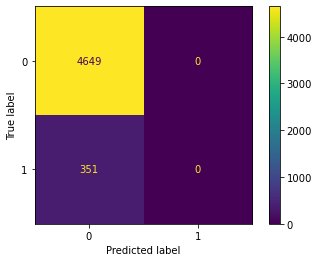

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
print('Precision:', precision_score(y_valid, y_pred))
print('Recall:', recall_score(y_valid, y_pred))
print('F1 score:', f1_score(y_valid, y_pred))
print('ROC AUC score:', roc_auc_score(y_valid, y_pred))

Precision: 0.0
Recall: 0.0
F1 score: 0.0
ROC AUC score: 0.5


Как видим, модель нисколько не справляется, попробуем подобрать гиперпараметры.

## Настройка гиперпараметров

Для начала попробуем найти метрику, которая выдает наилучший результат.

In [15]:
from sklearn.model_selection import GridSearchCV

clf = SVC()

kernel_values = {'kernel': ['linear', 'sigmoid', 'poly']}

clf_grid = GridSearchCV(clf, kernel_values, cv=5, scoring='f1')
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'kernel': ['linear', 'sigmoid', 'poly']},
             scoring='f1')

In [16]:
print(clf_grid.best_params_)
print(clf_grid.best_score_)
kernel_best = clf_grid.best_params_['kernel']

{'kernel': 'sigmoid'}
0.13632943461995956


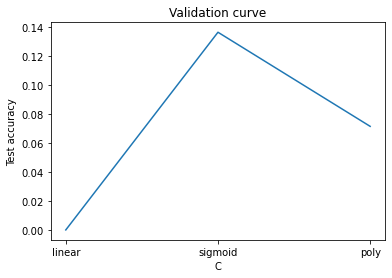

In [17]:
results_df = pd.DataFrame(clf_grid.cv_results_)
plt.plot(results_df['param_kernel'], results_df['mean_test_score'])

# Подписываем оси и график
plt.xlabel('kernel')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

In [18]:
y_pred = clf_grid.best_estimator_.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[4374  275]
 [ 299   52]]
F1 score valid: 0.15339233038348085


Можно увидеть, что лучше всего себя показала сигмоида, F1 составила около 15%. Теперь попробуем подобрать параметр С.

In [23]:
clf = SVC(kernel='sigmoid')

C_values = {'C': np.logspace(-1, 5, 30)}

clf_grid = GridSearchCV(clf, C_values, cv=5, scoring='f1')
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(kernel='sigmoid'),
             param_grid={'C': array([1.00000000e-01, 1.61026203e-01, 2.59294380e-01, 4.17531894e-01,
       6.72335754e-01, 1.08263673e+00, 1.74332882e+00, 2.80721620e+00,
       4.52035366e+00, 7.27895384e+00, 1.17210230e+01, 1.88739182e+01,
       3.03919538e+01, 4.89390092e+01, 7.88046282e+01, 1.26896100e+02,
       2.04335972e+02, 3.29034456e+02, 5.29831691e+02, 8.53167852e+02,
       1.37382380e+03, 2.21221629e+03, 3.56224789e+03, 5.73615251e+03,
       9.23670857e+03, 1.48735211e+04, 2.39502662e+04, 3.85662042e+04,
       6.21016942e+04, 1.00000000e+05])},
             scoring='f1')

In [24]:
print(clf_grid.best_params_)
print(clf_grid.best_score_)
C_best = clf_grid.best_params_['C']

{'C': 48.93900918477494}
0.14371930589972054


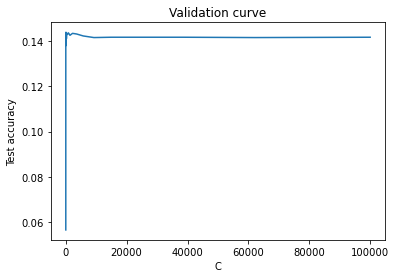

In [25]:
results_df = pd.DataFrame(clf_grid.cv_results_)
plt.plot(results_df['param_C'], results_df['mean_test_score'])

# Подписываем оси и график
plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

In [26]:
y_pred = clf_grid.best_estimator_.predict(X_valid)
print(confusion_matrix(y_valid, y_pred))
print('F1 score valid:', f1_score(y_valid, y_pred))

[[4295  354]
 [ 291   60]]
F1 score valid: 0.1568627450980392


Даже при подобранном параметре С никаких особых улучшений не наблюдается.